# Intialize

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class as Class_sz

In [2]:
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators and to avoid any ambiguity when comparing with camb. 
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665   
}

# Compute $\rho_c(z)$

In [6]:
%%time 
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'skip_background_and_thermo': 0,
'cosmo_model': 0,
})

CPU times: user 181 µs, sys: 973 µs, total: 1.15 ms
Wall time: 1.43 ms


True

In [7]:
%%time
classy_sz.compute_class_szfast()

CPU times: user 268 ms, sys: 136 ms, total: 404 ms
Wall time: 137 ms


In [8]:
classy_sz.get_rho_crit_at_z(0.)

277517901355.0651

# Plot $\rho(z)$

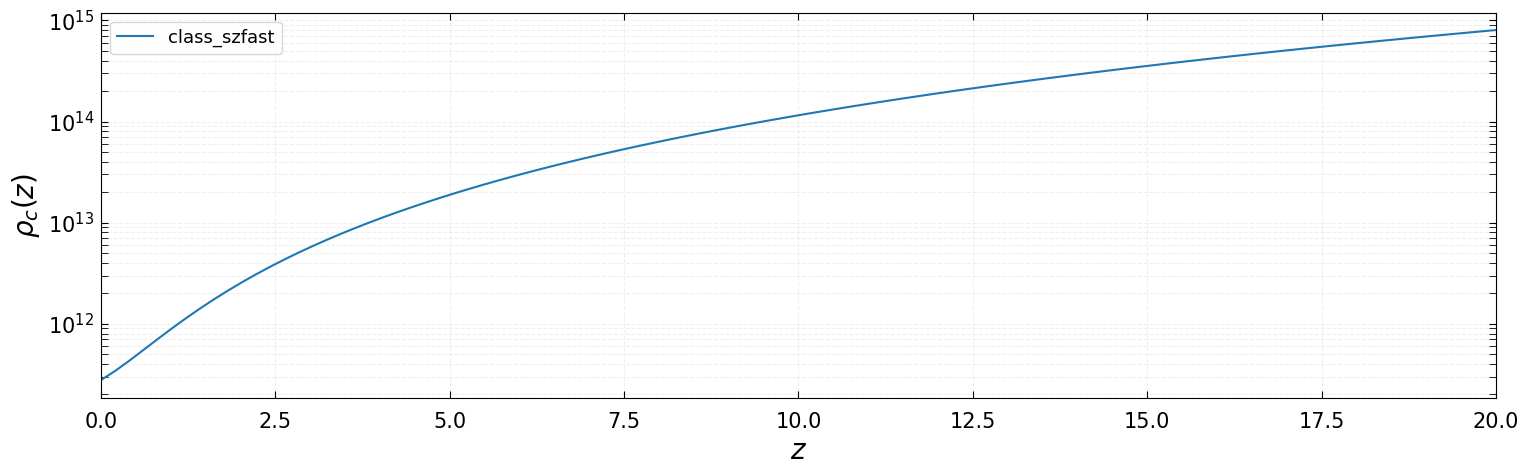

In [12]:
label_size = 15
title_size = 20
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(18,5))

ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


z = np.linspace(0.,20,100)

ax.plot(z,np.vectorize(classy_sz.get_rho_crit_at_z)(z),ls='-',label='class_szfast')






ax.set_ylabel(r"$\rho_c(z)$",size=title_size)
ax.set_xlabel(r"$z$",size=title_size)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(0,20)
ax.legend(fontsize=legend_size)

